In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db



In [2]:
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16

In [38]:
# load opsim database
dbpath_v15 = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

dbpath_v17 = "/home/idies/workspace/lsst_cadence/FBS_1.7/"

dbpath_v171 = "/home/idies/workspace/lsst_cadence/FBS_1.7.1/"


# output directory
dataRawDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir/tGaps/'

outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir/resultsDb/'
resultsDb = db.ResultsDb(outDir=outDir)



In [5]:
ls '/home/idies/workspace/Temporary/lixl/scratch/outDir/'

dataRaw/       dataRaw_v1_7/    properMotion/  tGaps/
dataRaw_v1_5/  dataRaw_v1_7_1/  resultsDb/


In [39]:
# get the name of all opsim dbs 
import glob

workpath = os.getcwd()
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns'

os.chdir(dbpath_v15)  # change to opsim database directory
dblist_v15 = glob.glob('*.db') 

os.chdir(dbpath_v17)  # change to opsim database directory
dblist_v17 = glob.glob('*.db') 

os.chdir(dbpath_v171)  # change to opsim database directory
dblist_v171 = glob.glob('*.db') 

os.chdir(workpath) # change back to work directory

dblist_v15.sort()
dblist_v17.sort()
dblist_v171.sort()


In [21]:
from lsst.sims.maf.utils import m52snr

class filterPairTGapsMetric(metrics.BaseMetric):
    """
    returns
    N_v * np.exp(-Dkl) for each fields
    
    Parameters:
        colname: 
        fltpair: filter pair, eg ['r', 'i']
        snr_lim: list, signal to noise ratio (fiveSigmaDepth) threshold for fltpair, default [5, 5]
        filename: output a csv table for time gaps of each field
    
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=['r', 'i'], tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
                 save_dT=False, filename=None, dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.mag_lim = mag_lim
        self.dataout = dataout
        self.tmin = tmin
        self.tmax = tmax
        self.bins = bins
        self.save_dT = save_dT
        
        self.Nrun = 0   # record the how many time run run()
        if filename!=None:
            if os.path.isfile(filename):
                # rm old file
                os.system("rm {}".format(filename))
                
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        #df = self.load_from_pkl(filename)

        #df = df.append(pd.DataFrame(dic), ignore_index=True)

        #df.to_pickle(filename)
        df = pd.DataFrame(dic)
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=None)
        
    def RADec2pix(self, nside, ra, dec, degree=True):
        """
        Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.
    
        Parameters
        ----------
        nside : int
            The nside value of the healpix grid.
        ra : numpy.ndarray
            The RA values to be converted to healpix ids, in degree by default.
        dec : numpy.ndarray
            The Dec values to be converted to healpix ids, in degree by default.
    
        Returns
        -------
        numpy.ndarray
            The healpix ids.
        """
        if degree:
            ra = np.radians(ra) # change to radians
            dec = np.radians(dec)
        
        lat = np.pi/2. - dec
        hpid = hp.ang2pix(nside, lat, ra )
        return hpid


    def run(self, dataSlice, slicePoint=None):
        
        # return all possible time gaps for each fields
        
        f0 = self.fltpair[0]
        f1 = self.fltpair[1]
        
        #check input config
        #print(f0, f1, self.tmin, self.tmax, self.mag_lim)
            
        # sort dataSlice
        
        idx0 = ( dataSlice['filter'] == f0 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[0])
        idx1 = ( dataSlice['filter'] == f1 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[1])
        
        timeCol0 = np.sort( dataSlice['observationStartMJD'][idx0] )
        timeCol1 = np.sort( dataSlice['observationStartMJD'][idx1] )

        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
        timeCol1 = timeCol1.reshape((len(timeCol1), 1))
        
        # calculate time gaps matrix
        diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) ) 
        
        # collect all time gaps
        if f0==f1:
            # get only triangle part
            dt_tri = np.tril(diffmat, -1)
            dT = dt_tri[dt_tri!=0]    # flatten lower triangle 
        else:
            dT = diffmat.flatten()

        #Nv, Dkl, FoM_i, dT_tlim = self.get_FoM_i(dT, tmin=self.tmin, tmax=self.tmax, bins=self.bins)
        
        dT_tlim = dT[(dT>=self.tmin)&(dT<=self.tmax)] 
        Nv = len(dT_tlim)

        # print(self.Nrun, np.min(dataSlice['fiveSigmaDepth'][idx0]), np.min(dataSlice['fiveSigmaDepth'][idx1]),)
        self.Nrun += 1
        # write results to csv file
        fieldRA = np.mean(dataSlice['fieldRA']) ,
        fieldDec = np.mean(dataSlice['fieldDec']),
        
        if self.save_dT:
            dic = {'Nrun': self.Nrun, 
                'pixId': self.RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                #'Dkl': Dkl,
                # 'FoM_i': FoM_i,
                'dT_lim': dT_tlim
                  }
        else:
            dic = {'Nrun': self.Nrun, 
                'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                #'Dkl': Dkl,
                #'FoM_i': FoM_i,
                # 'dT_lim': dT_tlim
                  }
            
        if self.filename!=None:
            self.save_to_file(dic, filename=self.filename)
        
        if self.dataout:
            # return dT
            result = dic
            return result
        else:
            #f0 = self.fltpair[0]
            #f1 = self.fltpair[1]
            #result = np.min(dT) if len(dT)!=0 else np.inf
            result = Nv
            return float(result) 

        

In [52]:
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

def runMetric(dbname, dbpath, fltpair, ipix_ms=None, nside=16, sqlstr=None,
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
              filename=None, dataout=True, **kwargs
             ):
    """run filterPairTGapsMetric
    dbname: name of opsim database
    fltpair: filter pair, eg: 'ri'
    ipix_ms: pixIds of footprint
    """
    opsdb = db.OpsimDatabase(dbpath+dbname)
    
    #fltpair = ['r', 'i']
    
    if ipix_ms!=None:
        # use UserPointsSlicer for minisurvey
        ra, dec = pix2radec(nside=nside, ipix=ipix_ms)
        slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    else:
        # use HealpixSlicer 
        slicer = slicers.HealpixSlicer(nside=nside)
    
    # metric, slicer, constraint
    metric = filterPairTGapsMetric( colname=colname, fltpair=fltpair, tmin=tmin, tmax=tmax, bins=bins, mag_lim=mag_lim,
                 filename=filename, dataout=dataout, **kwargs)
    
    sqlconstraint = 'filter in ("{}", "{}")'.format(*fltpair)
    if sqlstr!=None:
        sqlconstraint += ' and {}'.format(sqlstr)
        
    # bundle
    newMetricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    # group bundle
    bundleDict = {'newMetricSky':newMetricSky}
    group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
    
    # run
    group.runAll()
    #group.plotAll(closefigs = False)
    return newMetricSky



### run for one opsim one filter pair

In [22]:
dblist_v15[5]

'baseline_v1.5_10yrs.db'

In [29]:
%%time
# test run for baseline
dbname = dblist_v15[5]
metricSky = runMetric( dbname=dbname, dbpath=dbpath_v15, fltpair=['u', 'r'], ipix_ms=None, nside=16, sqlstr='proposalId=1',
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=2, bins=50, mag_lim=[18, 18],
              filename=None, dataout=True, save_dT=True)



Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 522979 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 9.01 s, sys: 3.38 s, total: 12.4 s
Wall time: 12.4 s


In [30]:
arr = metricSky.metricValues.data
arr_valid = arr[ arr != None ]
df = pd.DataFrame.from_records(arr_valid)
df.head(3)

Nrun  Nv                                             dT_lim  pixId
0     1  20  [0.01598771262797527, 0.015814308295375668, 0....   1376
1     2  17  [0.0159398090254399, 0.032145169119758066, 0.0...   1377
2     3  14  [0.015945262195600662, 0.01593982793565374, 0....   1378

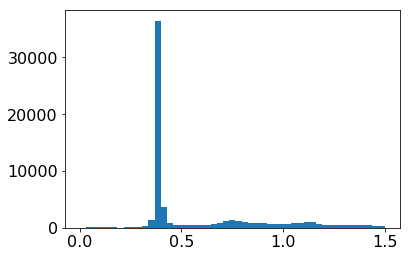

In [33]:
tmin = 5/60/60/24 # in days
tmax = 1.5/24
#tmax = 2
bins = np.linspace(tmin*24, tmax*24, 50)

dT_all = np.concatenate(df.dT_lim * 24)
plt.hist(dT_all[dT_all<1.5], bins=bins);

### run for all filterpairs all opsims

In [34]:
fltpairs = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy',
           'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy' ]

#### run for all opsim v1.5

In [42]:
%%time 
# run all filter pairs for all opsims 

nside = 16
# select mini survey footprint 
msname = 'ALL' # minisurvey label used to save files

if 'LMC' in msname:
    ipix_ms = ipix_LMC
elif 'SMC' in msname:
    ipix_ms = ipix_SMC
else:
    ipix_ms = None

#sqlstr = "night<4000 and proposalId=1"
#sqlstr = None
if 'WFD' in msname:
    sqlstr = "proposalId=1"
else:
    sqlstr = "note not like '%DD%'"

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
#diclist = []
#for Nrun in range( len(ipix_ms) ):
#    dic = {'Nrun': Nrun, 
#                'pixId': ipix_ms[Nrun],
#                'Nv': 0,
#                'Dkl': 0,
#                'FoM_i': 0,
#                'dT_lim': []
#                  }
#    diclist.append(dic)
#arr_empty = np.array(diclist)
#df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dbpath = dbpath_v15
for dbname in dblist_v15:
    dataRaw = {}
    dataRaw[dbname] = {}
    for fltpair in fltpairs: 
        
        print(">>> ", dbname, fltpair)

        dataRaw[dbname][fltpair] = {}
        if fltpair[0]==fltpair[1]:
            tmin =  5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            #tmin = 5/60/60/24
            tmin = 5/60/60/24  # 5s in days
            #tmax = 1.5/24 # 1.5 hour in days
            tmax = 2  # 2 days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, dbpath=dbpath, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
                
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        
        if len(df)==0:
            df = df_empty
            
        dataRaw[dbname][fltpair] = df[['pixId', 'Nv', 'dT_lim']] 
        
        # save raw data to pickle
        pd.DataFrame( dataRaw ).to_pickle(dataRawDir+'/tgaps_{}_{}.pkl'.format(dbname, msname))


>>>  agnddf_v1.5_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 137990 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  agnddf_v1.5_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 348456 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  agnddf_v1.5_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with co

Found 825640 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  agnddf_v1.5_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 409167 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 137491 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 423534 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 841464 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db yy
Healpix slicer usin

Found 469193 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 892183 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 889420 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runn

Found 821222 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 816189 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 435138 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.


Found 481496 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 964131 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 922139 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statisti

Found 633446 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 625714 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 467643 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 689232 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 637410 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db gy
Healpix slicer u

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bulge_wfd_v1.5_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 214976 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bulge_wfd_v1.5_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 680466 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bulge_wfd_v1.5_10yrs.d

Found 607461 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bs_v1.5_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 556811 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bs_v1.5_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 551293 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statisti

Found 349855 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 599533 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 607933 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 417076 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 134293 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 348378 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summar

Found 420287 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 834388 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 414101 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summar

Found 902522 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 896891 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 420265 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 449334 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 849917 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db iy
Healpix slicer u

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 885014 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 878937 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db ii
Healpix

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 467737 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 936623 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db rz
Heal

Found 683581 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugri_v1.5_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 631951 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugri_v1.5_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 625300 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 213050 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ug_v1.5_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 677088 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ug_v1.5_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 682580 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comple

Found 562649 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 555229 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 213361 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 609838 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 616263 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 560298 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 135186 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 623152 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 616201 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  

Found 366933 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 734888 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 737745 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 582017 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx2_v1.5_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 601315 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx2_v1.5_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 210169 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 578806 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx3_v1.5_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 567134 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx3_v1.5_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 529286 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 351270 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 543334 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 786477 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 809569 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 412459 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx5_v1.5_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 121010 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 983538 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx5_v1.5_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 572509 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx5_v1.5_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1167412 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistic

Found 657315 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx6_v1.5_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1057703 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx6_v1.5_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1070590 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statisti

Found 862409 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 879803 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 452592 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 438657 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 923059 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 919303 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 632634 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 626156 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 468201 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summ

Found 662037 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_dustv1.5_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 664761 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_dustv1.5_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 617963 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary 

Found 547521 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_nouiyv1.5_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 218871 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_nouiyv1.5_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 700673 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summar

Found 607090 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 556429 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 535491 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 352556 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 606597 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 609687 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 436704 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 138531 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 526463 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 340753 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 667135 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 326382 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 893468 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_gp_smoothv1.5_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 887975 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_gp_smoothv1.5_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 421211 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statis

Found 897083 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newAv1.5_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 469328 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newAv1.5_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 869381 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 934794 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newBv1.5_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 865855 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newBv1.5_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 897765 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 625455 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 467959 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 940175 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary st

Found 683028 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 632880 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 626665 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summ

Found 211882 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 679706 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 687767 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summar

Found 555521 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 548189 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 212430 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 605078 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gri_v1.5_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 609301 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gri_v1.5_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 557012 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 136170 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 347639 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 603543 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.


Found 833720 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 412154 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 135993 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 882947 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 422101 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 834448 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 474803 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_i_v1.5_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 896017 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_i_v1.5_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 887980 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comple

Found 879121 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  greedy_footprint_v1.5_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 880958 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  greedy_footprint_v1.5_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 477908 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 459599 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 927364 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 882488 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summ

Found 639305 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.10_v1.5_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 632480 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.10_v1.5_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 464877 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary 

Found 681551 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 686980 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 638611 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary 

Found 556884 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 216097 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 680577 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary 

Found 608748 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 559094 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 556687 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary 

Found 348739 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 596902 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 604992 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary 

Found 430112 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 135760 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 351727 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary 

Found 419787 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 850030 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 430243 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary 

Found 1017764 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_1expt_v1.5_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1006643 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_1expt_v1.5_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 479892 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary st

Found 987132 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_5expt_v1.5_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 530148 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_5expt_v1.5_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1003049 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary sta

Found 1225332 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_1expt_v1.5_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1157788 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_1expt_v1.5_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1142951 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary s

Found 789522 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_5expt_v1.5_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 591212 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_5expt_v1.5_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1188694 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary sta

Found 684544 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 634811 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 627161 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt120v1.5_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 683779 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt120v1.5_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 688392 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt120v1.5_10yrs.db gz
H

Found 557518 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt15v1.5_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 549786 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt15v1.5_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 211754 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 604168 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt30v1.5_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 607599 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt30v1.5_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 557679 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 135609 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 347373 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 603638 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 837600 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 415677 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 135380 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 888025 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 422082 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 837790 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 474188 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt90v1.5_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 898033 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt90v1.5_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 891105 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 1404190 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod1_v1.5_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1260143 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod1_v1.5_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 729726 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statis

Found 599330 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod2_v1.5_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1194988 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod2_v1.5_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1139162 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statis

Found 723619 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 680491 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 553134 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statisti

Found 751696 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 753680 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 700537 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statisti

Found 478737 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 202349 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 655089 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5

>>>  var_expt_v1.5_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 522341 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  var_expt_v1.5_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 520288 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  var_expt_v1.5_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps w

Found 648086 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_noddf_v1.5_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 652415 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_noddf_v1.5_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 598689 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running 

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 139983 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_v1.5_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 368257 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_v1.5_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with const

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_v1.5_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 794820 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_v1.5_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 361420 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_nod

Found 957387 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_noddf_v1.5_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 893188 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_noddf_v1.5_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 451833 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running 

Found 847731 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 480713 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 911799 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Found 1001744 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 948735 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 897435 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running

Found 601707 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 475843 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 954170 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Found 728990 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 676669 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 638642 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running 

Found 217034 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_v1.5_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 690102 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_v1.5_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 693572 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Found 587493 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_noddf_v1.5_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 565570 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_noddf_v1.5_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 224384 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running 

Found 607178 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 610947 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 561361 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Found 142565 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 364958 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 633934 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running 

Found 875164 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 433733 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_v1.5_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 135646 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summar

Found 887146 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_v1.5_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 421453 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_v1.5_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 836627 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Found 494117 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 932991 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 938597 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running 

Found 885723 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_v1.5_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 891250 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_v1.5_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 470825 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

Found 488951 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 981962 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 928486 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running 

Found 621822 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_v1.5_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 635836 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_v1.5_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 465861 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary stat

#### run for all opsim v1.7

In [44]:
%%time 
# run all filter pairs for all opsims 

nside = 16
# select mini survey footprint 
msname = 'ALL' # minisurvey label used to save files

if 'LMC' in msname:
    ipix_ms = ipix_LMC
elif 'SMC' in msname:
    ipix_ms = ipix_SMC
else:
    ipix_ms = None

#sqlstr = "night<4000 and proposalId=1"
#sqlstr = None
if 'WFD' in msname:
    sqlstr = "proposalId=1"
else:
    sqlstr = "note not like '%DD%'"

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
#diclist = []
#for Nrun in range( len(ipix_ms) ):
#    dic = {'Nrun': Nrun, 
#                'pixId': ipix_ms[Nrun],
#                'Nv': 0,
#                'Dkl': 0,
#                'FoM_i': 0,
#                'dT_lim': []
#                  }
#    diclist.append(dic)
#arr_empty = np.array(diclist)
#df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dbpath = dbpath_v17
for dbname in dblist_v17:
    dataRaw = {}
    dataRaw[dbname] = {}
    for fltpair in fltpairs: 
        
        print(">>> ", dbname, fltpair)

        dataRaw[dbname][fltpair] = {}
        if fltpair[0]==fltpair[1]:
            tmin =  5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            #tmin = 5/60/60/24
            tmin = 5/60/60/24  # 5s in days
            #tmax = 1.5/24 # 1.5 hour in days
            tmax = 2  # 2 days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, dbpath=dbpath, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
                
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        
        if len(df)==0:
            df = df_empty
            
        dataRaw[dbname][fltpair] = df[['pixId', 'Nv', 'dT_lim']] 
        
        # save raw data to pickle
        pd.DataFrame( dataRaw ).to_pickle(dataRawDir+'/tgaps_{}_{}.pkl'.format(dbname, msname))



>>>  baseline_nexp1_v1.7_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 134526 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_nexp1_v1.7_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 343294 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_nexp1_v1.7_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database

>>>  baseline_nexp1_v1.7_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 830781 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_nexp1_v1.7_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 411441 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_nexp2_v1.7_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database

>>>  baseline_nexp2_v1.7_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 815547 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_nexp2_v1.7_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 387606 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_nexp2_v1.7_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database

Found 812004 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  cadence_drive_gl100_gcbv1.7_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 426145 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  cadence_drive_gl100_gcbv1.7_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 807144 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summar

Found 858154 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  cadence_drive_gl100v1.7_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 813151 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  cadence_drive_gl100v1.7_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 805741 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statis

Found 639963 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  cadence_drive_gl200_gcbv1.7_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 445670 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  cadence_drive_gl200_gcbv1.7_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 850347 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summar

Found 681450 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  cadence_drive_gl200v1.7_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 640655 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  cadence_drive_gl200v1.7_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 637679 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statis

Found 197567 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  cadence_drive_gl30_gcbv1.7_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 630344 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  cadence_drive_gl30_gcbv1.7_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 628388 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary 

Found 508152 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  cadence_drive_gl30v1.7_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 501849 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  cadence_drive_gl30v1.7_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 195262 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statisti

Found 556082 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither0.00_v1.7_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 558515 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither0.00_v1.7_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 513171 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 125341 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither0.05_v1.7_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 319083 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither0.05_v1.7_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 555953 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 769012 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither0.05_v1.7_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 381369 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither0.10_v1.7_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 125970 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 813403 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither0.10_v1.7_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 387574 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither0.10_v1.7_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 768621 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 432529 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither0.30_v1.7_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 820130 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither0.30_v1.7_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 813788 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 817413 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither0.70_v1.7_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 811938 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither0.70_v1.7_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 433416 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 430781 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither1.00_v1.7_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 863549 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither1.00_v1.7_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 818164 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 581470 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither1.50_v1.7_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 575973 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither1.50_v1.7_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 430395 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 624009 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither2.00_v1.7_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 626766 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  ddf_dither2.00_v1.7_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 581223 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 507364 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  euclid_dither1_v1.7_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 193834 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  euclid_dither1_v1.7_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 623641 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 558588 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  euclid_dither2_v1.7_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 513179 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  euclid_dither2_v1.7_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 506729 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 318941 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  euclid_dither3_v1.7_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 555552 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  euclid_dither3_v1.7_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 558890 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 381627 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  euclid_dither4_v1.7_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 125757 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  euclid_dither4_v1.7_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 319087 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 386728 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  euclid_dither4_v1.7_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 768339 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  euclid_dither4_v1.7_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 381611 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 820358 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  euclid_dither5_v1.7_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 814412 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  euclid_dither5_v1.7_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 387367 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Co

Found 821681 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_0_v1.710yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 432871 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_0_v1.710yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 815803 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_1_v1.710yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 815306 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_1_v1.710yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 819505 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_1_v1.710yrs.db ii
Healpix slice

>>>  footprint_2_v1.710yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 428147 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_2_v1.710yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 859824 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_2_v1.710yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllP

Found 575756 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_3_v1.710yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 578647 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_3_v1.710yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 428640 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_4_v1.710yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 623912 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_4_v1.710yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 577873 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_4_v1.710yrs.db gy
Healpix slice

>>>  footprint_5_v1.710yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 189246 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_5_v1.710yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 617886 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_5_v1.710yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllP

Found 511738 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_6_v1.710yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 515566 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_6_v1.710yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 189638 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_7_v1.710yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 556504 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_7_v1.710yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 511570 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_7_v1.710yrs.db uy
Healpix slice

>>>  footprint_8_v1.710yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 317898 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_8_v1.710yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 554589 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_8_v1.710yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllP

Found 399100 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  pair_times_11_v1.7_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 116964 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  pair_times_11_v1.7_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 300523 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 369502 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  pair_times_11_v1.7_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 735935 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  pair_times_11_v1.7_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 366433 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 821022 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  pair_times_22_v1.7_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 815547 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  pair_times_22_v1.7_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 387606 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 821540 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  pair_times_33_v1.7_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 438849 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  pair_times_33_v1.7_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 831058 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 880752 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  pair_times_44_v1.7_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 832788 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  pair_times_44_v1.7_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 825391 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 589385 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  pair_times_55_v1.7_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 442281 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  pair_times_55_v1.7_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 884131 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 623571 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.2_nslice2_v1.7_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 579307 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.2_nslice2_v1.7_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 573506 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runn

>>>  rolling_nm_scale0.2_nslice3_v1.7_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 193045 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.2_nslice3_v1.7_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 621483 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.2_nslice3_v1.7_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 

>>>  rolling_nm_scale0.4_nslice2_v1.7_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 579517 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.4_nslice2_v1.7_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 574029 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.4_nslice2_v1.7_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 

Found 192653 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.4_nslice3_v1.7_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 621346 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.4_nslice3_v1.7_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 624161 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runn

>>>  rolling_nm_scale0.6_nslice2_v1.7_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 511869 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.6_nslice2_v1.7_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 505763 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.6_nslice2_v1.7_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 

Found 317051 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.6_nslice3_v1.7_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 554002 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.6_nslice3_v1.7_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 556227 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runn

>>>  rolling_nm_scale0.6_nslice3_v1.7_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 381754 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.8_nslice2_v1.7_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 124797 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.8_nslice2_v1.7_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 

Found 812770 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.8_nslice2_v1.7_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 386953 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.8_nslice2_v1.7_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 767820 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runn

>>>  rolling_nm_scale0.8_nslice3_v1.7_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 431963 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.8_nslice3_v1.7_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 819264 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.8_nslice3_v1.7_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 

Found 861467 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.9_nslice2_v1.7_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 816592 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.9_nslice2_v1.7_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 811216 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runn

>>>  rolling_nm_scale0.9_nslice3_v1.7_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 574461 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.9_nslice3_v1.7_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 429998 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.9_nslice3_v1.7_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 

Found 622471 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale1.0_nslice2_v1.7_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 624895 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale1.0_nslice2_v1.7_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 580822 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runn

>>>  rolling_nm_scale1.0_nslice3_v1.7_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 506230 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale1.0_nslice3_v1.7_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 194012 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale1.0_nslice3_v1.7_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 

Found 553890 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.2_nslice2_v1.7_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 557108 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.2_nslice2_v1.7_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 512400 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 124613 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.2_nslice3_v1.7_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 317440 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.2_nslice3_v1.7_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 554685 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 770687 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.2_nslice3_v1.7_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 382534 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.4_nslice2_v1.7_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 125079 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 816104 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.4_nslice2_v1.7_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 387805 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.4_nslice2_v1.7_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 770868 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 432731 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.4_nslice3_v1.7_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 820277 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.4_nslice3_v1.7_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 815951 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 388150 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.6_nslice2_v1.7_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 771777 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.6_nslice2_v1.7_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 383627 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 821645 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.6_nslice3_v1.7_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 815628 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.6_nslice3_v1.7_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 388679 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 813178 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.8_nslice2_v1.7_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 433471 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.8_nslice2_v1.7_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 822524 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 388308 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.8_nslice3_v1.7_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 771677 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.8_nslice3_v1.7_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 383369 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 821678 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.9_nslice2_v1.7_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 816900 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.9_nslice2_v1.7_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 388489 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 813640 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.9_nslice3_v1.7_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 433848 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale0.9_nslice3_v1.7_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 822558 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 864392 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale1.0_nslice2_v1.7_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 818731 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale1.0_nslice2_v1.7_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 814152 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale1.0_nslice3_v1.7_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 823209 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale1.0_nslice3_v1.7_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 817581 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_scale

Found 1478458 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern1_v1.7_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1109497 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern1_v1.7_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 783350 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statisti

Found 605972 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern2_v1.7_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1221666 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern2_v1.7_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1141955 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statisti

Found 665600 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern3_v1.7_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 550990 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern3_v1.7_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 550792 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 708664 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern4_v1.7_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 711352 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern4_v1.7_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 639661 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 475328 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern5_v1.7_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 181513 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern5_v1.7_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 792447 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 715403 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern6_v1.7_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 632324 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern6_v1.7_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 478755 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 306591 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern7_v1.7_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 674354 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_neo_pattern7_v1.7_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 679648 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 365280 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_pairs_mixed_repeat_v1.7_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 124047 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_pairs_mixed_repeat_v1.7_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 316155 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summar

Found 382266 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_pairs_mixed_repeat_v1.7_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 764469 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_pairs_mixed_repeat_v1.7_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 382203 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summar

Found 820912 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_pairs_mixed_v1.7_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 819941 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_pairs_mixed_v1.7_10yrs.db zz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 382107 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.


Found 819088 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_pairs_repeat_v1.7_10yrs.db ii
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 436408 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_pairs_repeat_v1.7_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 827721 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 870365 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_pairs_v1.7_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 825973 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twi_pairs_v1.7_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 818435 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>

Found 582910 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u_long_ms_30_v1.7_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 437838 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u_long_ms_30_v1.7_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 878152 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comple

Found 628037 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u_long_ms_40_v1.7_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 581940 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u_long_ms_40_v1.7_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 575447 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comple

Found 191844 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u_long_ms_50_v1.7_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 615880 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u_long_ms_50_v1.7_10yrs.db gi
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 618608 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comple

Found 495150 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u_long_ms_60_v1.7_10yrs.db uy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 488496 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u_long_ms_60_v1.7_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 189137 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comple

#### run for all opsim v1.7.1

In [48]:
%%time 
# run all filter pairs for all opsims 

nside = 16
# select mini survey footprint 
msname = 'ALL' # minisurvey label used to save files

if 'LMC' in msname:
    ipix_ms = ipix_LMC
elif 'SMC' in msname:
    ipix_ms = ipix_SMC
else:
    ipix_ms = None

#sqlstr = "night<4000 and proposalId=1"
#sqlstr = None
if 'WFD' in msname:
    sqlstr = "proposalId=1"
else:
    sqlstr = "note not like '%DD%'"

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
#diclist = []
#for Nrun in range( len(ipix_ms) ):
#    dic = {'Nrun': Nrun, 
#                'pixId': ipix_ms[Nrun],
#                'Nv': 0,
#                'Dkl': 0,
#                'FoM_i': 0,
#                'dT_lim': []
#                  }
#    diclist.append(dic)
#arr_empty = np.array(diclist)
#df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dbpath = dbpath_v171
for dbname in dblist_v171:
    dataRaw = {}
    dataRaw[dbname] = {}
    for fltpair in fltpairs: 
        
        print(">>> ", dbname, fltpair)

        dataRaw[dbname][fltpair] = {}
        if fltpair[0]==fltpair[1]:
            tmin =  5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            #tmin = 5/60/60/24
            tmin = 5/60/60/24  # 5s in days
            #tmax = 1.5/24 # 1.5 hour in days
            tmax = 2  # 2 days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, dbpath=dbpath, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
                
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        
        if len(df)==0:
            df = df_empty
            
        dataRaw[dbname][fltpair] = df[['pixId', 'Nv', 'dT_lim']] 
        
        # save raw data to pickle
        pd.DataFrame( dataRaw ).to_pickle(dataRawDir+'/tgaps_{}_{}.pkl'.format(dbname, msname))


>>>  baseline_nexp2_v1.7.1_10yrs.db uu
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 127001 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_nexp2_v1.7.1_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 321023 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_nexp2_v1.7.1_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying da

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_nexp2_v1.7.1_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 767798 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_nexp2_v1.7.1_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 380634 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulge_roll_scale0.90_nslice2_

Found 431328 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulge_roll_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 817244 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulge_roll_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 814610 visits
Running:  ['newMetricSky']
Completed metric generation.


Found 859608 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 814489 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 813184 visits
Running:  ['newMetricSky']
Completed metric generation.


Found 578426 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_6_v1.7.1_10yrs.db rr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 428512 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_6_v1.7.1_10yrs.db ri
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 859748 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comp

Found 621960 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  full_disk_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db gz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 576762 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  full_disk_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db gy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 565546 visits
Running:  ['newMetricSky']
Completed metric generation.
Ru

Found 502203 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  full_disk_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db gg
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 189230 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  full_disk_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db gr
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 619343 visits
Running:  ['newMetricSky']
Completed metric generation.
Ru

Found 555201 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  full_disk_v1.7_10yrs.db ui
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 558023 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  full_disk_v1.7_10yrs.db uz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 512191 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>

Found 125618 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db ug
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 318253 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db ur
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 554642 visits
Running:  ['newMetricSky']
Completed metric generation.


Found 386563 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db zy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 762299 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7_10yrs.db yy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 375736 visits
Running:  ['newMetricSky']
Completed metric generation.


Found 432195 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db iz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 819377 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_nm_scale0.90_nslice3_fpw0.9_nrw1.0v1.7_10yrs.db iy
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 809384 visits
Running:  ['newMetricSky']
Completed metric generation.


Found 862491 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  six_stripe_scale0.90_nslice6_fpw0.9_nrw0.0v1.7_10yrs.db rz
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 817797 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  six_stripe_scale0.90_nslice6_fpw0.9_nrw0.0v1.7_10yrs.db ry
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 816184 visits
Running:  ['newMetricSky']
Completed metric generation.


### minisurveys regions: LMC SMC GP

In [50]:
ipix_LMC = [2899, 2900, 2901, 2934, 2935, 2936, 2965, 2966, 2967, 2992, 2993, 2994]
ipix_SMC = [2960, 2961, 2988, 2989, 3012]
ipix_GP = [ 144,  145,  146,  147,  179,  180,  181,  182,  183,  184,  217,
        218,  219,  225,  226,  260,  261,  271,  272,  307,  308,  320,
        321,  358,  374,  413,  431,  432,  471,  472,  493,  534,  535,
        558,  598,  599,  622,  661,  662,  687,  725,  726,  751,  788,
        789,  790,  815,  816,  852,  853,  854,  879,  915,  916,  917,
        944,  979,  980,  981, 1008, 1042, 1043, 1044, 1045, 1073, 1107,
       1108, 1109, 1136, 1170, 1171, 1172, 1201, 1234, 1235, 1236, 1237,
       1265, 1297, 1298, 1299, 1300, 1330, 1361, 1362, 1363, 1364, 1393,
       1425, 1426, 1427, 1428, 1458, 1489, 1490, 1491, 1492, 1522, 1552,
       1553, 1554, 1555, 1587, 1616, 1617, 1618, 1619, 1620, 1650, 1679,
       1680, 1681, 1682, 1683, 1715, 1744, 1745, 1746, 1747, 1779, 1807,
       1808, 1809, 1810, 1811, 1843, 1871, 1872, 1873, 1874, 1875, 1907,
       1934, 1935, 1936, 1937, 1938, 1972, 1998, 1999, 2000, 2001, 2002,
       2003, 2036, 2062, 2063, 2064, 2065, 2066, 2100, 2126, 2127, 2128,
       2129, 2130, 2164, 2189, 2190, 2191, 2192, 2193, 2194, 2229, 2253,
       2254, 2255, 2256, 2257, 2258, 2293, 2316, 2317, 2318, 2319, 2320,
       2321, 2358, 2380, 2381, 2382, 2383, 2384, 2385, 2421, 2422, 2443,
       2444, 2445, 2446, 2447, 2448, 2449, 2486, 2487, 2507, 2508, 2509,
       2510, 2511, 2512, 2513, 2550, 2551, 2570, 2571, 2572, 2573, 2574,
       2575, 2576, 2614, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2673,
       2687, 2688, 2689, 2690, 2691, 2692, 2693, 2728, 2729, 2739, 2740,
       2741, 2742, 2743, 2744, 2745, 2746, 2779, 2780, 2781, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2826, 2827, 2828, 2829, 2830,
       2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2869, 2870,
       2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2908, 2909,
       2910, 2911, 2912, 2913, 2914, 2915, 2916, 2943, 2944, 2945, 2946,
       2947, 2948, 2974, 2975, 2976]


In [58]:
%%time 
# run all filter pairs for all opsims 

nside = 16
# select mini survey footprint 
msname = 'SMC_WFD' # minisurvey label used to save files

if 'LMC' in msname:
    print(f"running {msname}")
    ipix_ms = ipix_LMC
elif 'SMC' in msname:
    print(f"running {msname}")
    ipix_ms = ipix_SMC
elif 'GP' in msname:
    print(f"running {msname}")
    ipix_ms = ipix_GP
else:
    ipix_ms = None

#sqlstr = "night<4000 and proposalId=1"
#sqlstr = None
if 'WFD' in msname:
    sqlstr = "proposalId=1"
else:
    sqlstr = "note not like '%DD%'"

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
diclist = []
for Nrun in range( len(ipix_ms) ):
    dic = {#'Nrun': Nrun, 
                'pixId': ipix_ms[Nrun],
                'Nv': 0,
                'dT_lim': []
                  }
    diclist.append(dic)
arr_empty = np.array(diclist)
df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dbpath = dbpath_v15
for dbname in dblist_v15:
    dataRaw = {}
    dataRaw[dbname] = {}
    for fltpair in fltpairs: 
        
        print(">>> ", dbname, fltpair)

        dataRaw[dbname][fltpair] = {}
        if fltpair[0]==fltpair[1]:
            tmin =  5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            #tmin = 5/60/60/24
            tmin = 5/60/60/24  # 5s in days
            #tmax = 1.5/24 # 1.5 hour in days
            tmax = 2  # 2 days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, dbpath=dbpath, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
                
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        
        if len(df)==0:
            df = df_empty
            
        dataRaw[dbname][fltpair] = df[['pixId', 'Nv', 'dT_lim']] 
        
        # save raw data to pickle
        pd.DataFrame( dataRaw ).to_pickle(dataRawDir+'/tgaps_{}_{}.pkl'.format(dbname, msname))



running SMC_WFD
>>>  agnddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 119740 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  agnddf_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 291301 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  agnddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 523025 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce met

Found 487961 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 448627 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 466629 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveS

Found 163429 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 531555 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 534862 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposal

Found 534264 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 495728 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 513123 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldD

Found 417657 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 835674 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 797384 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', '

Found 787742 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 408057 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 773375 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveS

Found 659748 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 302878 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 624138 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fi

Found 317799 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bs_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 101790 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bs_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 247417 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bs_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', '

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 433194 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 435495 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'five

Found 436681 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 401247 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 419129 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for column

Found 419005 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 144088 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 476391 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec'

Found 552319 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 511237 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 528067 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fi

Found 404045 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 811043 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 766983 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'fil

Found 787216 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 405879 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 769494 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

Found 789295 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugri_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 363686 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugri_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 745362 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugri_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec'

Found 381404 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 125146 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 299908 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

Found 530013 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 534435 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 486868 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec'

Found 493187 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 170832 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 570583 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigm

Found 669853 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 674092 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 689499 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fie

Found 441440 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx2_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 885613 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx2_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 838559 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx2_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fie

Found 770698 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx3_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 390222 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx3_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 746014 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx3_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fie

Found 768610 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 360750 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 735664 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fie

Found 540313 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx6_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 117625 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx6_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 289312 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx6_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fie

Found 601736 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 602009 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 563117 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fie

Found 575141 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 172565 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 570914 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fie

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 571422 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 529982 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSig

Found 533413 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_dustv1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 550845 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_dustv1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 404256 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_dustv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns [

Found 432616 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_nouiyv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 869385 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_nouiyv1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 822476 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_nouiyv1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for column

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 823160 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 426141 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observatio

Found 817149 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 840573 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 385965 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fie

Found 285190 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 582189 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 296999 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_gp_smoothv1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for column

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newAv1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 96920 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newAv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 232848 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newAv1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD'

Found 528715 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 485690 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 503800 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fi

Found 501058 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 172630 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 577990 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for col

Found 584495 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 589843 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 545395 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for column

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 554703 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 404972 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD

Found 813320 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gri_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 769299 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gri_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 786396 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gri_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec'

Found 406375 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 771223 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 787072 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldD

Found 365234 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 746599 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 381365 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_i_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'f

Found 118919 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  greedy_footprint_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 291750 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  greedy_footprint_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 525930 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  greedy_footprint_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fie

Found 483810 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 446043 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 468370 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for col

Found 503887 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.10_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 177335 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.10_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 577978 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.10_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns [

Found 576549 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 579914 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 538806 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns [

Found 541345 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 566345 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 401333 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns [

Found 400451 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 805535 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 763462 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns [

Found 768294 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 801850 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 407946 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns [

Found 405885 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 769472 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 805377 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns [

Found 898300 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_1expt_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 415348 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_1expt_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 848976 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_1expt_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['field

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_5expt_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 427355 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_1expt_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 163085 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_1expt_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'o

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_5expt_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 378943 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_5expt_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 670301 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_5expt_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'o

Found 526686 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 484249 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 502000 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigm

Found 173737 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt120v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 582202 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt120v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 584810 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt120v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec'

Found 538330 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt15v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 555521 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt15v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 405233 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt15v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

Found 813781 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt30v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 771104 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt30v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 788708 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt30v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

Found 407869 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 773480 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 791999 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

Found 365678 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 749845 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 384167 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt90v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

Found 124813 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod1_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 328961 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod1_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 671371 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod1_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', '

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod2_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 603378 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod2_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 554219 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod2_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observa

Found 548197 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 186634 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 641974 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', '

Found 628131 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 582385 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 597053 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', '

Found 391605 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 786179 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 745873 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'ob

Found 741114 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  var_expt_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 385471 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  var_expt_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 724609 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  var_expt_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveS

Found 656963 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_noddf_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 674691 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_noddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 310232 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_noddf_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 f

Found 296124 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 609951 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 313827 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_noddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns [

Found 341082 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 104460 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 252558 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['field

Found 274756 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 486979 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 488859 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 f

Found 466142 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 430391 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 447530 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['field

Found 487888 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 169506 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 560911 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 f

Found 533386 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 535451 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 497275 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['field

Found 544584 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_noddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 563214 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_noddf_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 409653 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_noddf_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 f

Found 389331 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 781115 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 740558 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['field

Found 810851 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 828860 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 428511 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 f

Found 408721 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 774641 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 792679 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['field

Found 865951 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 400176 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 818290 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 f

Found 780899 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 399178 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 128725 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for col

Found 122711 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 306492 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 562352 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['field

In [59]:
%%time 
# run all filter pairs for all opsims 

nside = 16
# select mini survey footprint 
msname = 'SMC_ALL' # minisurvey label used to save files

if 'LMC' in msname:
    print(f"running {msname}")
    ipix_ms = ipix_LMC
elif 'SMC' in msname:
    print(f"running {msname}")
    ipix_ms = ipix_SMC
elif 'GP' in msname:
    print(f"running {msname}")
    ipix_ms = ipix_GP
else:
    ipix_ms = None

#sqlstr = "night<4000 and proposalId=1"
#sqlstr = None
if 'WFD' in msname:
    sqlstr = "proposalId=1"
else:
    sqlstr = "note not like '%DD%'"

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
diclist = []
for Nrun in range( len(ipix_ms) ):
    dic = {#'Nrun': Nrun, 
                'pixId': ipix_ms[Nrun],
                'Nv': 0,
                'dT_lim': []
                  }
    diclist.append(dic)
arr_empty = np.array(diclist)
df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dbpath = dbpath_v15
for dbname in dblist_v15:
    dataRaw = {}
    dataRaw[dbname] = {}
    for fltpair in fltpairs: 
        
        print(">>> ", dbname, fltpair)

        dataRaw[dbname][fltpair] = {}
        if fltpair[0]==fltpair[1]:
            tmin =  5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            #tmin = 5/60/60/24
            tmin = 5/60/60/24  # 5s in days
            #tmax = 1.5/24 # 1.5 hour in days
            tmax = 2  # 2 days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, dbpath=dbpath, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
                
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        
        if len(df)==0:
            df = df_empty
            
        dataRaw[dbname][fltpair] = df[['pixId', 'Nv', 'dT_lim']] 
        
        # save raw data to pickle
        pd.DataFrame( dataRaw ).to_pickle(dataRawDir+'/tgaps_{}_{}.pkl'.format(dbname, msname))




running SMC_ALL
>>>  agnddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 137990 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  agnddf_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 348456 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  agnddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 603123 visits
Running:  ['newMetricSky']
Completed metric genera

Found 600897 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 610123 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 561025 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fie

Found 562590 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 559827 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 223118 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "

Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 195861 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 627607 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 630999 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce method

Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 706170 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 664178 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 636572 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce me

Found 625714 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 467643 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 939374 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fie

Found 887606 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 882138 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 473693 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', '

Found 473590 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bulge_wfd_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 895443 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bulge_wfd_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 890029 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bs_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for

Found 637942 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 632587 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 465189 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and n

Found 463439 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 944868 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 883726 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note no

Found 883422 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 877791 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 482257 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for column

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 849917 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 843097 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observa

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 418817 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 831557 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth',

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 412569 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugri_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 139742 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugri_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDe

Found 144831 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ug_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 357881 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ug_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 608869 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ug_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fi

Found 611502 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 611331 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 562649 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns [

Found 560298 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 556196 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 213997 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for column

Found 209371 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 670607 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 672843 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldD

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 742411 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 759170 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'five

Found 666734 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx2_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 486301 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx2_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 975589 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx2_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for 

Found 870724 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx3_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 832876 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx3_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 848687 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx3_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for 

Found 847666 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 433256 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 830366 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for 

Found 441092 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx6_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1098407 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx6_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 841480 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx6_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for

Found 862409 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 879803 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 452592 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for 

Found 484402 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 965048 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 984989 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for 

Found 886647 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 421755 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 837032 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note

Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 858630 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_dustv1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 443446 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_nouiyv1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 130174 visits
Running:  ['newMetricSky']
Completed metric generation.
Running 

Found 417347 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 127217 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 339984 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for 

Found 352556 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 606597 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 609687 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for 

Found 598236 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 479284 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 464913 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and n

Found 550540 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_gp_smoothv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 209529 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_gp_smoothv1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 678353 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_gp_smoothv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%

Found 677718 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newAv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 678891 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newAv1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 609616 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newAv1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns [

Found 611221 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newBv1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 643131 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newBv1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 466386 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newBv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns [

Found 467959 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 940175 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 889583 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like

Found 889016 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 882801 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 471387 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note

Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 475885 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 898717 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 897769 visits
Running:  ['newMetricSky']
Completed metric generation.
Running

Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 885871 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 420160 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 832988 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
R

Found 831949 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gri_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 412024 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 136170 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for colu

Found 135993 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 348037 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 603315 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns [

Found 602146 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_i_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 609437 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_i_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 555848 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_i_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fi

Found 550038 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  greedy_footprint_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 551875 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  greedy_footprint_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 212879 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  greedy_footprint_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for 

Found 221340 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 680939 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 689105 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note

Found 687694 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.10_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 639305 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.10_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 632480 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.10_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not l

Found 632799 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 464358 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 934145 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not l

Found 935677 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 886570 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 884573 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not l

Found 883321 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 471075 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 892496 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not l

Found 893402 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 901800 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 421714 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not l

Found 419787 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 850030 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 430243 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_1expt_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not lik

Found 468771 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_5expt_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 157057 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_5expt_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 395530 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_5expt_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%

Found 466694 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_1expt_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 797104 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_1expt_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 803880 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_1expt_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%

Found 780096 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_5expt_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 715111 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_5expt_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 701381 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_5expt_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%

Found 551396 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 211942 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 680248 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldD

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt120v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 417523 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt15v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 135826 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt15v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDep

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt30v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 347576 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt30v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 604168 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt30v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDept

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 607067 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 557532 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDept

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 551088 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 212363 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDept

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt90v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 682870 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt90v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 686858 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt90v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDept

Found 957881 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod1_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 900493 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod1_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 756446 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod1_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' f

Found 703222 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod2_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 599330 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod2_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1194988 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod2_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' 

Found 1107940 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1053341 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1010213 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%

Found 976684 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 533066 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1012989 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' 

>>>  u60_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 858231 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 409683 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 812077 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce meth

Found 778701 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  var_expt_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 388324 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_noddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 145039 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_noddf_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '

Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 139983 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 368257 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 619032 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduc

Found 381186 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_noddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 645551 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_noddf_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 649883 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_noddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") an

Found 619777 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 570150 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 509924 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%

Found 542285 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 233271 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 732526 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") an

Found 697363 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 699847 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 651192 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%

Found 676669 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 638642 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 496712 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") an

Found 473068 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 949606 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 900561 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%

Found 938948 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_noddf_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 917025 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_noddf_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 497885 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_noddf_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") an

Found 474168 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 898750 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 877918 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%

Found 927728 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 441431 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 875164 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") an

Found 836627 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 415174 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 140283 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note

Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 133364 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 341625 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 599712 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduc

Found 349957 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 626337 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 630397 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") an

Found 601006 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 551552 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 565566 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%

In [55]:
%%time 
# run all filter pairs for all opsims 

nside = 16
# select mini survey footprint 
msname = 'GP_WFD' # minisurvey label used to save files

if 'LMC' in msname:
    print(f"running {msname}")
    ipix_ms = ipix_LMC
elif 'SMC' in msname:
    print(f"running {msname}")
    ipix_ms = ipix_SMC
elif 'GP' in msname:
    print(f"running {msname}")
    ipix_ms = ipix_GP
else:
    ipix_ms = None

#sqlstr = "night<4000 and proposalId=1"
#sqlstr = None
if 'WFD' in msname:
    sqlstr = "proposalId=1"
else:
    sqlstr = "note not like '%DD%'"

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
diclist = []
for Nrun in range( len(ipix_ms) ):
    dic = {#'Nrun': Nrun, 
                'pixId': ipix_ms[Nrun],
                'Nv': 0,
                'dT_lim': []
                  }
    diclist.append(dic)
arr_empty = np.array(diclist)
df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dbpath = dbpath_v15
for dbname in dblist_v15:
    dataRaw = {}
    dataRaw[dbname] = {}
    for fltpair in fltpairs: 
        
        print(">>> ", dbname, fltpair)

        dataRaw[dbname][fltpair] = {}
        if fltpair[0]==fltpair[1]:
            tmin =  5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            #tmin = 5/60/60/24
            tmin = 5/60/60/24  # 5s in days
            #tmax = 1.5/24 # 1.5 hour in days
            tmax = 2  # 2 days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, dbpath=dbpath, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
                
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        
        if len(df)==0:
            df = df_empty
            
        dataRaw[dbname][fltpair] = df[['pixId', 'Nv', 'dT_lim']] 
        
        # save raw data to pickle
        pd.DataFrame( dataRaw ).to_pickle(dataRawDir+'/tgaps_{}_{}.pkl'.format(dbname, msname))





running GP_WFD
>>>  agnddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 119740 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  agnddf_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 291301 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  agnddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 523025 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce meth

Found 487961 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 448627 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 466629 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveS

Found 163429 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 531555 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 534862 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposal

Found 534264 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 495728 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 513123 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldD

Found 417657 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 835674 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 797384 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', '

Found 787742 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 408057 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 773375 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveS

Found 659748 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 302878 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 624138 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fi

>>>  bulges_bulge_wfd_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 317799 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bs_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 101790 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bs_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 247417 visits
Running:  ['newMetricSky']
Completed metric generation.
Ru

Found 245570 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 433194 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 435495 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for 

Found 436681 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 401247 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 419129 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for column

Found 419005 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 144088 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 476391 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec'

Found 552319 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 511237 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 528067 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fi

Found 404045 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 811043 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 766983 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'fil

Found 787216 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 405879 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 769494 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

>>>  dcr_nham1_ugri_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 789295 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugri_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 363686 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugri_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 745362 visits
Running:  ['newMetricSky']
Completed metric generation.
Running re

Found 744169 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ug_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 381404 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 125146 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'f

Found 300353 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 530013 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 534435 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec'

Found 475750 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 493187 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 170832 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigm

Found 667603 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 669853 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 674092 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fie

Found 605573 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx2_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 441440 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx2_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 885613 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx2_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fie

>>>  filterdist_indx3_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 756490 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx3_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 770698 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx3_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 390222 visits
Running:  ['newMetricSky']
Completed metric generation.
Runn

Found 393696 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 754446 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 768610 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fie

>>>  filterdist_indx5_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 519749 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx5_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1060062 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx5_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 540313 visits
Running:  ['newMetricSky']
Completed metric generation.
Run

Found 375440 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 190839 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 435044 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fie

Found 518703 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 560123 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 556850 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fie

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 494503 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 169920 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSig

Found 169649 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_dustv1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 573905 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_dustv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 575610 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_dustv1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns [

Found 621980 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_nouiyv1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 575071 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_nouiyv1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 593342 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_nouiyv1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for column

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 423757 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 849898 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observatio

>>>  footprint_big_wfdv1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 814498 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 837922 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 431184 visits
Running:  ['newMetricSky']
Completed metric generation.
Runn

>>>  footprint_bluer_footprintv1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 397639 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 682829 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 694638 visits
Running:  ['newMetricSky']
Completed

>>>  footprint_gp_smoothv1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 737616 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_gp_smoothv1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 339816 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_gp_smoothv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 697909 visits
Running:  ['newMetricSky']
Completed metric generation

Found 583801 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newAv1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 300401 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newBv1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 102748 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newBv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

Found 292654 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 526263 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 528715 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fi

Found 525588 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 482830 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 501058 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for col

Found 505961 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 175718 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 584495 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for column

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 581475 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 537078 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD

Found 553981 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gri_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 405252 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gri_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 813320 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gri_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec'

>>>  goodseeing_griz_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 769540 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 785389 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 406375 visits
Running:  ['newMetricSky']
Completed metric generation.
Running

Found 406596 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 771830 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 787961 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

Found 364520 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_i_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 746679 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_i_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 382159 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  greedy_footprint_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 

>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 111274 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 274720 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 480436 visits
Running:  ['newMetricSky']
Completed me

Found 521046 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.10_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 524489 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.10_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 483462 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.10_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns [

Found 482932 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 504298 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 176796 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns [

Found 177380 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 578713 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 583115 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns [

Found 582922 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 540849 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 565534 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns [

Found 577631 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 402684 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 810630 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns [

Found 806992 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 764694 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 800599 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns [

Found 895447 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_1expt_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 464672 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_1expt_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 880020 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_1expt_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['field

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_5expt_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 885093 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_5expt_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 409132 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_5expt_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'o

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_1expt_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 969283 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_1expt_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 494267 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_5expt_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'o

>>>  spiders_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 117962 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 291119 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 523685 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running

Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 528596 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt120v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 486908 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt120v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 503554 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statist

Found 500255 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt15v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 173012 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt15v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 578245 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt15v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 580978 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt30v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 538301 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt30v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 555905 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistic

Found 557279 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 405742 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 813611 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

Found 772229 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 790718 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 408443 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

Found 777619 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt90v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 795556 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt90v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 367397 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt90v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', '

>>>  twilight_neo_mod1_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 989921 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod1_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 497397 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod2_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 123355 visits
Running:  ['newMetricSky']
Completed metric generation.
R

Found 122537 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 309171 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 577877 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', '

Found 566643 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 520897 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 535565 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', '

Found 165418 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 557023 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 559992 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'ob

Found 503343 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  var_expt_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 523119 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  var_expt_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 382200 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  var_expt_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveS

>>>  wfd_depth_scale0.65_noddf_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 690916 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_noddf_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 469232 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 471331 visits
Running:  ['newMetricSky']
Completed me

Found 516835 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_noddf_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 478588 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_noddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 496602 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_noddf_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 f

Found 474452 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 340938 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 684590 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['field

Found 751316 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 711785 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 730366 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 f

Found 696551 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 358355 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 680959 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['field

Found 746491 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 764531 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 352820 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 f

Found 336628 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 691038 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 354410 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_noddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns [

Found 386696 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 115638 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 283154 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['field

Found 306920 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 551378 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 552654 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 f

Found 526431 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 483630 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 501668 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['field

Found 544345 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 187878 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 633865 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 f

Found 602958 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 604911 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 560293 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['field

Found 607667 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 626733 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 461740 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 f

Found 439641 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 881641 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and proposalId=1 for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 834981 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and proposalId=1 for columns ['field

In [56]:
%%time 
# run all filter pairs for all opsims 

nside = 16
# select mini survey footprint 
msname = 'GP_ALL' # minisurvey label used to save files

if 'LMC' in msname:
    print(f"running {msname}")
    ipix_ms = ipix_LMC
elif 'SMC' in msname:
    print(f"running {msname}")
    ipix_ms = ipix_SMC
elif 'GP' in msname:
    print(f"running {msname}")
    ipix_ms = ipix_GP
else:
    ipix_ms = None

#sqlstr = "night<4000 and proposalId=1"
#sqlstr = None
if 'WFD' in msname:
    sqlstr = "proposalId=1"
else:
    sqlstr = "note not like '%DD%'"

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
diclist = []
for Nrun in range( len(ipix_ms) ):
    dic = {#'Nrun': Nrun, 
                'pixId': ipix_ms[Nrun],
                'Nv': 0,
                'dT_lim': []
                  }
    diclist.append(dic)
arr_empty = np.array(diclist)
df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dbpath = dbpath_v15
for dbname in dblist_v15:
    dataRaw = {}
    dataRaw[dbname] = {}
    for fltpair in fltpairs: 
        
        print(">>> ", dbname, fltpair)

        dataRaw[dbname][fltpair] = {}
        if fltpair[0]==fltpair[1]:
            tmin =  5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            #tmin = 5/60/60/24
            tmin = 5/60/60/24  # 5s in days
            #tmax = 1.5/24 # 1.5 hour in days
            tmax = 2  # 2 days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, dbpath=dbpath, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
                
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        
        if len(df)==0:
            df = df_empty
            
        dataRaw[dbname][fltpair] = df[['pixId', 'Nv', 'dT_lim']] 
        
        # save raw data to pickle
        pd.DataFrame( dataRaw ).to_pickle(dataRawDir+'/tgaps_{}_{}.pkl'.format(dbname, msname))





running GP_ALL
>>>  agnddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 137990 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  agnddf_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 348456 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  agnddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 603123 visits
Running:  ['newMetricSky']
Completed metric generat

Found 600897 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 610123 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 561025 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_dust_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fie

Found 562590 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 559827 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 223118 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "

Found 195861 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 627607 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 630999 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_2snaps_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for col

Found 706170 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 664178 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 636572 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_samefilt_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' f

Found 625714 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 467643 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 939374 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  baseline_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fie

>>>  bulges_bs_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 887606 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 882138 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bs_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 473693 visits
Running:  ['newMetricSky']
Completed metric generation.
R

>>>  bulges_bulge_wfd_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 473590 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bulge_wfd_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 895443 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_bulge_wfd_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 890029 visits
Running:  ['newMetricSky']
Completed

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bs_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 890090 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bs_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 422479 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bs_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'f

Found 422431 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 839507 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_bulge_wfd_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 417076 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_cadence_i_heavy_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and not

>>>  bulges_cadence_i_heavy_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 414101 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 133937 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  bulges_i_heavy_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 347605 visits
Running:  ['newMetricSky']
Complet

Found 333119 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 576454 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 579696 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  daily_ddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', '

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 557336 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 551259 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ug_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth',

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 212011 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 679748 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugr_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDept

Found 678785 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugri_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 683581 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugri_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 631951 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham1_ugri_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for column

Found 631111 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ug_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 625508 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ug_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 464038 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ug_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fi

Found 467832 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 935493 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 886811 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugr_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns [

Found 883344 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 879242 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 472867 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  dcr_nham2_ugri_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for column

>>>  descddf_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 877253 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 870302 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  descddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 413781 visits
Running:  ['newMetricSky']
Completed metric generation.
Running

>>>  filterdist_indx1_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 375478 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 767715 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx1_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 392237 visits
Running:  ['newMetricSky']
Completed

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx2_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 456565 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx3_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 137608 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx3_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'five

Found 351270 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 543334 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 786477 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx4_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for 

Found 507491 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx5_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 509645 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx5_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 693519 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx5_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for 

Found 529911 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx6_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 542798 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx6_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 189061 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx6_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for 

Found 269043 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 721523 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 721635 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx7_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for 

Found 674260 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 670504 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 690445 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  filterdist_indx8_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for 

Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 626156 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 468201 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_add_mag_cloudsv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 939571 visits
Running:  ['newMetricSky']
Completed metric generation.
Runni

Found 459258 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_dustv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 921240 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_dustv1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 874442 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_dustv1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not l

>>>  footprint_big_sky_nouiyv1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 918206 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_nouiyv1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 899149 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_sky_nouiyv1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 446624 visits
Running:  ['newMet

Found 881558 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 479873 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 909085 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_skyv1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for 

Found 879192 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 900195 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 415701 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_big_wfdv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for 

>>>  footprint_bluer_footprintv1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 340753 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 667135 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_bluer_footprintv1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 326382 visits
Running:  ['

Found 836929 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_gp_smoothv1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 415718 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newAv1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 150990 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newAv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for colu

Found 152606 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newBv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 364358 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newBv1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 618992 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_newBv1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns [

Found 603450 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 607707 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 557115 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_no_gp_northv1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like

Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 556971 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 550756 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_standard_goalsv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 211641 visits
Running:  ['newMetricSky']
Completed metric generation.
Runni

Found 554492 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 211882 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 679706 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  footprint_stuck_rollingv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note no

Found 680057 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 685473 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 632590 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gi_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns [

Found 631942 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gri_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 624041 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gri_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 467991 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gri_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for column

Found 467373 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 937418 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 888939 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_griz_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for col

Found 889423 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 879669 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 470600 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_gz_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns [

Found 474803 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_i_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 896017 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_i_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 887980 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  goodseeing_i_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fi

Found 892535 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  greedy_footprint_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 412790 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  greedy_footprint_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 827417 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  greedy_footprint_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for 

>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 842573 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 419684 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.10_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 138676 visits
Running:  ['newMe

Found 415379 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 139531 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 356724 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod2_sdf_0.20_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not l

Found 352888 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 601271 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 607988 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.10_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not l

Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 608748 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 559094 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod3_sdf_0.20_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 556687 visits
Running:  ['newMetricSky']
Completed metric generation.
Running r

Found 555018 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 563416 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 215435 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.10_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not l

Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 215967 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 678675 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  rolling_mod6_sdf_0.20_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 685928 visits
Running:  ['newMetricSky']
Completed metric generation.
Running r

Found 775819 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_1expt_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 780590 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_1expt_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 722610 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_1expt_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%

Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 711374 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_5expt_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 700568 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_2ns_5expt_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 525037 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduc

Found 812541 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_1expt_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 609278 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_1expt_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1225332 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_1expt_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '

Found 1188694 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_5expt_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1123709 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_5expt_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1109979 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  short_exp_5ns_5expt_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like

Found 883525 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 472602 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 895471 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  spiders_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldD

Found 901499 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt120v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 893144 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt120v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 425878 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt120v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for column

Found 421692 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt15v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 835652 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt15v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 413960 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt30v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns [

Found 414390 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 135609 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 347373 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt45v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns [

Found 347743 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 604356 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 607697 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt60v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns [

Found 610012 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt90v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 559669 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt90v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 552741 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  third_obs_pt90v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns [

Found 669510 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod1_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 228155 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod1_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 960007 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod1_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' f

Found 825737 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod2_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 822065 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod2_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 766239 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod2_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' f

Found 723619 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 680491 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 553134 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod3_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' f

Found 531082 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1064148 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 1011005 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  twilight_neo_mod4_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%'

>>>  u60_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 855134 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 455837 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  u60_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 865520 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce meth

Found 838019 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  var_expt_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 835966 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  var_expt_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 390377 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  var_expt_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fie

>>>  wfd_depth_scale0.65_noddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 453650 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_noddf_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 831582 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_noddf_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 377932 visits
Running: 

Found 794820 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.65_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 361420 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_noddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 144329 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_noddf_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note

>>>  wfd_depth_scale0.70_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 139064 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 364436 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.70_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 615935 visits
Running:  ['newMetricSky']


Found 377376 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 643360 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 646594 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_noddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") an

Found 616544 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 567889 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 518404 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.75_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%

Found 553487 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 229240 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 725952 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_noddf_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") an

Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 690102 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 693572 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.80_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 644527 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduc

Found 722269 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_noddf_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 668538 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_noddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 646615 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_noddf_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") an

>>>  wfd_depth_scale0.85_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 617346 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 470399 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.85_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 944567 visits
Running:  ['newMetricSky']


Found 491369 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 985364 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 932800 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_noddf_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") an

>>>  wfd_depth_scale0.90_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 888846 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 882567 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.90_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 471972 visits
Running:  ['newMetricSky']


Found 933993 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 494117 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 932991 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_noddf_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") an

Found 890200 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 895727 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 419375 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.95_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%

>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 439535 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 894110 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_noddf_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 454575 visits
Running: 

Found 854504 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>>  wfd_depth_scale0.99_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth', 'observationStartMJD']
Found 434259 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 3h 53min 27s, sys: 1h 49min 52s, total: 5h 43min 20s
Wall time: 6h 1min
